In [1]:
library("limma")
library("edgeR")

In [2]:
LFC = 1.0
p = 0.05

subt <- "bic84" #  

In [3]:
design <- read.delim("UKE_181.design.tsv", row.names = 1)
rowSums(t(design))
head(design,3)

bic84 bic130 
    82     68

,bic84,bic130
,<int>,<int>
T0063,1,0
T0096,1,0
T0294,0,0


In [5]:
# RNA-seq counts
exprs <- read.delim("../data/210706_rawcounts.csv.gz", row.names = 1, sep = ",")
exprs <- exprs[,sort(rownames(design))]
head(exprs,3)
exprs <- DGEList(exprs)

,T0063,T0096,T0294,T0305,T0315,T0342,T0430,T0644,T0797,T0848,⋯,T6981,T6984,T6987,T6990,T6991,T6993,T6995,T6999,T7001,T7003
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2881,1061,2628,714,1320,2094,1651,1404,1301,682,⋯,1853,849,707,509,492,669,825,442,280,962
ENSG00000000005,2,0,4,5,6,54,9,1,2,1,⋯,11,12,1,0,1,10,1,0,6,6
ENSG00000000419,412,538,527,377,728,635,811,280,540,414,⋯,408,839,727,359,492,607,816,406,307,731


In [6]:
# limma-voom
diff_expression_rna <- function(exprs, design_m, subt) {
    dm <- design_m[subt]
    dm[paste0("not_",subt)] = 1- dm[subt]

    group1 <- subt
    group2 <- paste0("not_",subt)
    all_groups <- c(group1,group2)

    group <- as.factor(apply(dm, 1, function(x) { all_groups[as.logical(x)]}))

    keep_exprs <- filterByExpr(exprs, group=group,min.prop = 0.05)
    cat(paste0("Genes passed filterByExprs: ", length(keep_exprs[keep_exprs])))
    exprs <- exprs[keep_exprs,, keep.lib.sizes=FALSE]
    exprs <- calcNormFactors(exprs, method = "upperquartile") 

    # making simple contrast matrix
    contrasts_matrix <- makeContrasts(contrasts=paste0(subt," - ",paste0("not_",subt)),levels=dm)

    voom_results <-  voom(exprs, dm, plot = T, save.plot=F)
    fit <- lmFit(voom_results, dm,plot = T, save.plot=F)
    contr_fit <- contrasts.fit(fit, contrasts_matrix)
    result <- eBayes(contr_fit)
    table_res <- topTable(result, adjust="BH",resort.by="P",p.value=1,confint=TRUE,number=dim(exprs$counts)[1]) 

    return(table_res)
}

Genes passed filterByExprs: 24575

[1] 855

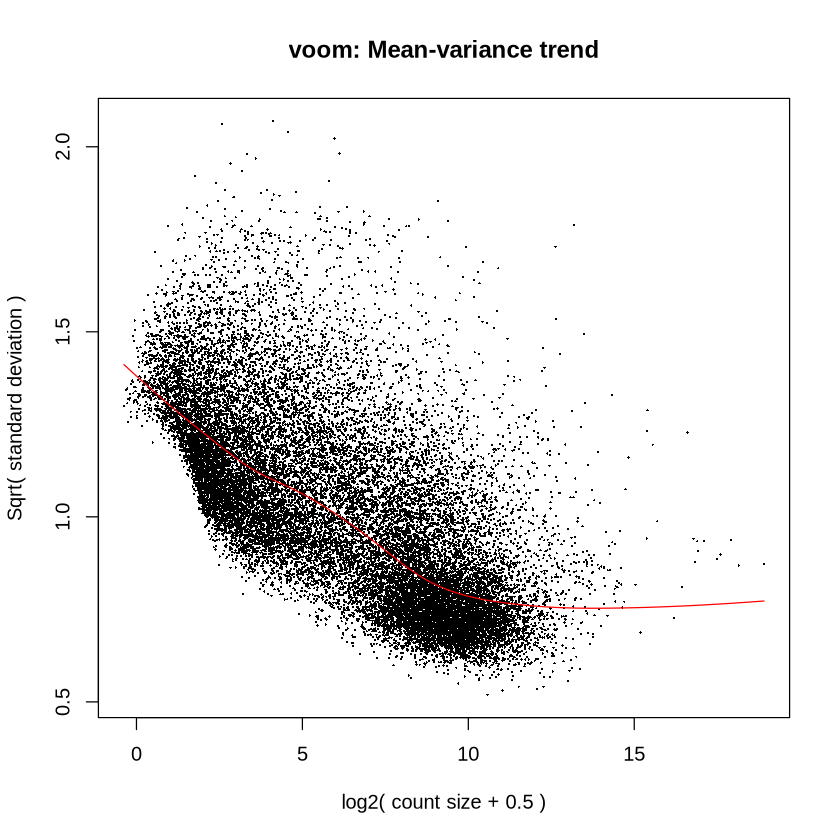

In [7]:
results <- diff_expression_rna(exprs, design, subt)
r <- results[abs(results$logFC)>LFC,]
r <- r[abs(r$adj.P.Val)<p,]
dim(r)[[1]]
##cat(paste(rownames(r),sep = " "))
write.table(results,paste0(subt,"_UKE181.DE.tsv"),sep = "\t", quote = FALSE, row.names = T)

### best match of a bicluster in DASL
* DASL is micrtoarray-based ->  limma is used 

In [8]:
design <- read.delim("DASL_377.design.tsv", row.names = 1)
rowSums(t(design))
head(design,3)

bic84 bic130 
   182     52

,bic84,bic130
,<int>,<int>
X5800701006_B,0,0
X5800701006_C,0,0
X5800701006_D,0,0


In [9]:
exprs <- read.delim("../data/DASL.exprs_Kommoss.tsv.gz", row.names = 1)
exprs <- exprs[,sort(rownames(design))]
dim(design)
dim(exprs)
head(exprs,2)

[1] 377   2

[1] 19369   377

,X5800701006_B,X5800701006_C,X5800701006_D,X5800701006_E,X5800701006_F,X5800701006_G,X5800701006_I,X5800701006_J,X5800701006_K,X5800701006_L,⋯,X6828280034_C,X6828280034_F,X6828280034_H,X6828280034_I,X6828280034_J,X6828280034_K,X6828280034_L,X6828301015_B,X6828301015_C,X6828301015_D
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,9.909752,9.525017,9.389951,8.906697,8.872511,9.435739,8.682605,8.263090,10.024749,7.500624,⋯,8.821913,9.981615,8.306561,9.164281,7.774171,8.969784,10.373839,9.417089,9.138731,8.597400
ENSG00000000005,5.796944,6.934209,6.029834,8.056683,5.848083,10.293842,12.859131,5.729206,7.629308,5.864953,⋯,7.105938,6.985320,7.148474,7.285059,7.248570,8.255288,9.003298,7.328400,7.132316,8.051942


In [10]:
diff_expression_microarrays <- function(exprs, design_m, subt) {
    dm <- design_m[subt]
    dm[paste0("not_",subt)] = 1- dm[subt]

    group1 <- subt
    group2 <- paste0("not_",subt)
    all_groups <- c(group1,group2)

    group <- as.factor(apply(dm, 1, function(x) { all_groups[as.logical(x)]}))
    
    contrasts_matrix <- makeContrasts(contrasts=paste0(subt," - ",paste0("not_",subt)),levels=dm)
    
    fit <- lmFit(exprs, dm,plot = T, save.plot=F)
    contr_fit <- contrasts.fit(fit, contrasts_matrix)
    result <- eBayes(contr_fit)
    table_res <- topTable(result, adjust="BH",resort.by="P",p.value=1,confint=TRUE,number=dim(exprs)[1]) 

    return(table_res)
}

In [11]:
results <- diff_expression_microarrays(exprs, design, subt)
r2 <- results[abs(results$logFC)>LFC,]
r2 <- r2[abs(r2$adj.P.Val)<p,]
dim(r2)[[1]]
#cat(paste(rownames(r2),sep = " "))
write.table(results,paste0(subt,"_DASL377.DE.tsv"),sep = "\t", quote = FALSE, row.names = T)

[1] 133

In [24]:
design <- read.delim("TCGA-OV_426.design.tsv", row.names = 1)
rowSums(t(design))
head(design,3)

bic84 bic130 
   164     89

,bic84,bic130
,<int>,<int>
TCGA-13-1485-01,1,0
TCGA-25-1315-01,0,0
TCGA-09-0369-01,0,0


In [25]:
# RNAseq - TOIL RSEM expected_counts
exprs <- read.delim("../data/TCGA-OV_noENSG00000230417_UKEgenes.est_counts_rounded.tsv", row.names = 1, sep = "\t")
dim(exprs )
names(exprs) <- gsub("\\.", "-", names(exprs))
exprs <- exprs[,rownames(design)]
head(exprs,3)
exprs <- DGEList(exprs)

[1] 23457   426

,TCGA-13-1485-01,TCGA-25-1315-01,TCGA-09-0369-01,TCGA-24-1419-01,TCGA-29-1761-01,TCGA-24-1845-01,TCGA-24-2293-01,TCGA-29-A5NZ-01,TCGA-29-1768-01,TCGA-24-1426-01,⋯,TCGA-61-1733-01,TCGA-23-1107-01,TCGA-24-1930-01,TCGA-24-1430-01,TCGA-61-1721-01,TCGA-29-1784-01,TCGA-13-0725-01,TCGA-13-1481-01,TCGA-61-1907-01,TCGA-24-2254-01
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000242268,0,0,0,0,0,0,3,0,0,0,⋯,0,0,0,0,2,0,2,2,0,4
ENSG00000270112,4,9,0,2,11,14,16,9,0,3,⋯,27,8,25,6,1,49,3,7,0,2
ENSG00000167578,950,1349,2527,4137,2019,1500,1839,697,616,1892,⋯,1047,1852,3380,1906,637,2401,1823,2089,1285,824


Genes passed filterByExprs: 22756

[1] 1004

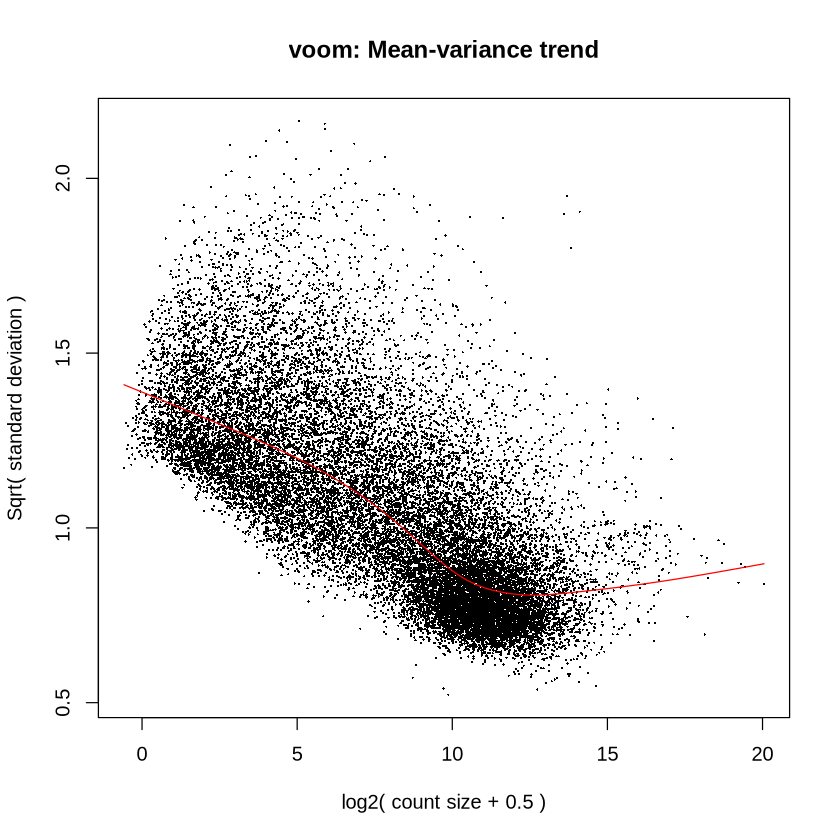

In [17]:
results <- diff_expression_rna(exprs, design, subt)
r3 <- results[abs(results$logFC)>LFC,]
r3 <- r3[abs(r3$adj.P.Val)<p,]
dim(r3)[[1]]
#cat(paste(rownames(r2),sep = " "))
write.table(results,paste0(subt,"_TCGA-OV426.DE.tsv"),sep = "\t", quote = FALSE, row.names = T)

In [14]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/olya/anaconda3/envs/r4_env/lib/libopenblasp-r0.3.17.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] edgeR_4.0.16 limma_3.58.1

loaded via a namespace (and not attached):
 [1] digest_0.6.36     IRdisplay_1.1     utf8_1.2.4        base64enc_0.1-3  
 [5] fastmap_1.2.0     lattice_0.22-6    glue_1.7.0        htmltools_0.5.8.1
